In [1]:
import pandas as pd
import numpy as np

In [110]:
# First off merge the generator data from powerworld with generator data from excel
powerworld_gen = pd.read_csv('powerworldGen.csv')
gen_units = pd.read_csv('GenUnits.csv')
curves = pd.read_csv("./backup/curves_linearized.csv")

#discard various unused columns
genu_drop = ["GenFuelType", "Utility ID", "Utility Name", "Plant Name", "State", "County", "Prime Mover", "EIA Generator ID",
            "EIA-860 Plant Name", "Prime Mover", "Unit Code", "Ownership", "Duct Burners", "Can Bypass Heat Recovery Steam Generator?",
            "RTO/ISO LMP Node Designation", "RTO/ISO Location Designation for Reporting Wholesale Sales Data to FERC", "Nameplate Capacity (MW)",
            "Nameplate Power Factor", "Summer Capacity (MW)", "Winter Capacity (MW)", "Uprate or Derate Completed During Year",
            "Month Uprate or Derate Completed", "Year Uprate or Derate Completed", "Status", "Synchronized to Transmission Grid",
            "Operating Month", "Operating Year", "Planned Retirement Month", "Planned Retirement Year", "Associated with Combined Heat and Power System",
            "Sector Name", "Sector", "Topping or Bottoming", "Energy Source 2", "Energy Source 3", "Energy Source 4", "Energy Source 5", "Energy Source 6",
            "Startup Source 1", "Startup Source 2", "Startup Source 3", "Startup Source 4", "Solid Fuel Gasification System?", "Carbon Capture Technology?",
            "Turbines or Hydrokinetic Buoys", "Fluidized Bed Technology?", "Pulverized Coal Technology?","Stoker Technology?","Other Combustion Technology?",
            "Subcritical Technology?", "Supercritical Technology?","Ultrasupercritical Technology?","Planned Net Summer Capacity Uprate (MW)",
            "Planned Net Winter Capacity Uprate (MW)","Planned Uprate Month","Planned Uprate Year","Planned Net Summer Capacity Derate (MW)","Planned Net Winter Capacity Derate (MW)",
             "Planned Derate Month", "Planned Derate Year","Planned New Prime Mover","Planned Energy Source 1","Planned New Nameplate Capacity (MW)",
             "Planned Repower Month","Planned Repower Year","Other Planned Modifications?","Other Modifications Month","Other Modifications Year","Multiple Fuels?",
             "Cofire Fuels?","Switch Between Oil and Natural Gas?"]
gen_units = gen_units.drop(genu_drop, axis=1)

pw_drop = ["Status","AGC","# Cost Curve Points","IOB","IOC","Variable O&M","IOD","AVR","Enforce MW Limits","Cost Model"]
powerworld_gen = powerworld_gen.drop(pw_drop, axis = 1)


# create unique IDs to merge the data on
powerworld_gen["BUS UID"] = powerworld_gen.apply(lambda x: "{}{}".format(x["Number of Bus"], x["ID"]), axis = 1)
gen_units["BUS UID"] = gen_units.apply(lambda x: "{}{}".format(x["BusNum"], x["GenID"]), axis = 1)
curves["BUS UID"] = curves.apply(lambda x: "{}{}".format(int(x["Number of Bus"]), int(x["ID"])), axis = 1)

curves_drop = ["Name of Bus", "Area Name of Gen", "Status", "AGC", "Fuel Type","Unit Type", "Cost Shift $/MWh", "Cost Multiplier",
              "Fixed Cost(Mbtu/hr)", "MW Break 6", "MW Break 7", "MW Break 8", "MW Break 9", "MW Break10", "MW Break11", "MW Break12", 
               "MW Break13", "MW Break14", "MW Break15", "MW Break16", "MW Break17", "MW Break18", "MW Break19", "MW Break20",
              "MWh Price 6", "MWh Price 7","MWh Price 8","MWh Price 9","MWh Price10","MWh Price11","MWh Price12","MWh Price13","MWh Price14",
               "MWh Price15","MWh Price16","MWh Price17","MWh Price18","MWh Price19","MWh Price20", "Number of Bus", "ID",
              "Gen MW", "Max MW", "Min MW", "Fuel Cost"]
              
curves = curves.drop(["ID","Number of Bus"], axis = 1)

gen_merge = powerworld_gen.merge(gen_units, how = "left", on = "BUS UID", validate="one_to_one", copy=False)
gen_merge_1 = gen_merge.merge(curves, how = "left", on = "BUS UID", validate="one_to_one", copy=False)
gen_merge_1.to_csv("gen_merge.csv")


In [111]:
# add in the logic to calculate cold start
def cold_start(x):
    if(x == "OVER"):
        return 13
    elif(x == "12H"):
        return 12
    elif(x == "1H"):
        return 1
    elif(x == "10M"):
        return 1/6
    else:
        return 0

gen_master = pd.read_csv("gen_merge.csv")

gen_master["Start Time Cold Hr"] = gen_master["Time from Cold Shutdown to Full Load"].apply(cold_start)
gen_master["Start Time Warm Hr"] = gen_master["Start Time Cold Hr"].apply(lambda x: x/2)
gen_master["Start Time Hot Hr"] = gen_master["Start Time Cold Hr"].apply(lambda x: x/4)

gen_master = gen_master.drop("Time from Cold Shutdown to Full Load", axis = 1)
gen_master.to_csv("gen_step_2.csv")

In [112]:
# merge in UC parameters
gen_master = pd.read_csv("gen_step_2.csv")
uc_param = pd.read_csv("GenUCParams.csv")

# create unique ids
uc_param["GEN UID"] = uc_param.apply(lambda x: "{}_{}_{}".format(x["PlantCode"], x["Technology"].replace(" ",""), x["GeneratorID"]), axis=1)
gen_master["GEN UID"] = gen_master.apply(lambda x: "{}_{}_{}".format(x["Plant Code"], x["Technology"].replace(" ",""), x["Generator ID"]), axis=1)


# drop extraneous
uc_drop = ["PlantName", "WinterCapacityMW", "PlantCode","GeneratorID", "Technology", "WinterCapacityMW"]
uc_param = uc_param.drop(uc_drop, axis = 1)

gen_step_3 = gen_master.merge(uc_param, how = "left", on = "GEN UID", validate="one_to_one", copy=False)
gen_step_3.to_csv("gen_step_3.csv")

In [113]:
# rename all the relevant columns
gen_master = pd.read_csv("gen_step_3.csv")

gen_master["Non Fuel Start Cost $"] = np.zeros(731)
gen_master = gen_master.rename({"Number of Bus":"Bus ID",
                               "Technology": "Unit Type",
                               "Fuel Type": "Fuel",
                               "Min MW": "PMin MW",
                               "Max MW": "PMax MW",
                               "minDnHr": "Min Down Time Hr",
                               "minUpHr": "Min Up Time Hr",
                               "RRMWperMin": "Ramp Rate MW/Min",
                               "Fuel Cost":"Fuel Price $/MMBTU"}, axis=1)
# artifacts of the merges
gen_master = gen_master.drop(["Unnamed: 0","Unnamed: 0.1", "Unnamed: 0.1.1"], axis=1)

gen_master.to_csv("gen_step_4.csv")

0.0030044067350458404
0.0030044067165872434
0.0030044067350458404
4.00587564672756
4.005875646727796
4.005875629563321
[0.13928906 0.993      0.996      1.        ]
0.003003267460722069
0.003003267473118277
0.0030032675070677094
4.004356614296341
4.004356614295867
4.004356633425336
[0.15717188 0.993      0.996      1.        ]
0.0029989030068660774
0.002998903093434337
0.0029989030068660744
3.9985373424878015
3.9985373424889965
3.9985373658859373
[0.47422407 0.993      0.996      1.        ]
0.0030039968431771927
0.00300399684333791
0.0030039968431771927
4.00532912423604
4.005329124236738
4.005329124322714
[0.17821757 0.993      0.996      1.        ]
0.005105388130608531
0.005105388159879344
0.005105388130608559
3.0031694894899132
3.003169488518477
3.003169461449717
[0.28906284 0.35       0.7        1.        ]
0.002730402981446961
0.002730403014098225
0.002730402981446962
1.606119401638376
1.6061194121634221
1.6061194200577618
[0.28074592 0.35       0.7        1.        ]
0.007696727

2.5935386409033714
2.593538640903375
2.593538640903367
[0.32598684 0.652      0.827      1.        ]
0.004399916765755086
0.004399916741004802
0.004399916765755088
1.3950275097511136
1.3950275048865826
1.3950275097511626
[0.22493088 0.5        0.75       1.        ]
0.003873684210526263
0.003873684210526263
0.003873684210526263
1.2007700590595907
1.2007700590595907
1.2007700590595785
[0.12683824 0.5        0.75       1.        ]
0.01615357204923973
0.016153572463768185
0.016153572773352748
5.816914701889319
5.8169148683882135
5.816914823106581
[0.4925 0.5    0.75   1.    ]
0.015333852132049599
0.015333851546391816
0.015333851444291374
5.183858056811865
5.183857899644466
5.183857824304107
[0.46536765 0.652      0.827      1.        ]
0.002657622737556771
0.0026576229508196865
0.0026576221719456657
0.814222652437762
0.8142226899200189
0.8142226012951344
[0.42874677 0.652      0.827      1.        ]
0.0013616392326732283
0.001361638390092744
0.0013616392326734482
0.41336953025903406
0.413

<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))



0.6189630470808074
0.6189630470808143
[0.26538462 0.652      0.827      1.        ]
0.00916242903487436
0.00916242949756866
0.00916242903487436
2.7917212172073107
2.7917212172072383
2.79172134553461
[0.11914286 0.652      0.827      1.        ]
0.017292867283949992
0.01729286611740496
0.01729286728395072
5.556833960138254
5.5568338092786265
5.556833868512351
[0.30614286 0.652      0.827      1.        ]
0.012380876244665552
0.01238087749287773
0.012380876244665552
3.961880398293033
3.9618806811622997
3.96188085348641
[0.498 0.5   0.8   1.   ]
0.012938489333333318
0.01293849132176237
0.012938489333333318
4.225502721532731
4.225503119725507
4.225502968952314
[0.46289398 0.652      0.827      1.        ]
0.014980627906976822
0.01498062822719425
0.014980627906976822
4.62507808180818
4.625078088210787
4.625078146979846
[0.15826087 0.652      0.827      1.        ]
0.01271047065217408
0.012710471226927145
0.012710471739130294
3.995746825581261
3.9957469094063334
3.99574707354481
[0.33289855

<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
<ipython-input-133-1b7739b8dfd1>:1


6.049513634684683
6.049514002859009
[0.16157895 0.6        0.8        1.        ]
0.010565909547739538
0.010565909319899413
0.010565909547737761
3.491708376648987
3.491708337317169
3.4917083126408652
[0.47710526 0.6        0.8        1.        ]
0.006682285198554838
0.006682285714285752
0.006682285198556119
2.3332001391599992
2.333200236779176
2.333200439042455
[0.27131579 0.6        0.8        1.        ]
0.005312868949232788
0.005312868949232785
0.005312868949232788
1.6031590070104416
1.6031590070106687
1.6031590070103612
[0.25701754 0.652      0.827      1.        ]
0.001425583892617715
0.0014255834031854748
0.0014255838926171193
0.4046505514101562
0.40465054562631925
0.4046504594367792
[0.14814286 0.652      0.827      1.        ]
0.011050662761506303
0.011050662479061502
0.011050662761506898
3.371160085877453
3.3711600825716195
3.371160028833027
[0.14685714 0.652      0.827      1.        ]
0.006980802792320968
0.006980802792320968
0.00698080279232097
2.0228347703046445
2.0228347

5.120694775867851
5.120694775867382
5.12069477586649
[0.12650602 0.652      0.827      1.        ]
0.0012696397968898368
0.0012696396825396682
0.001269639796889949
0.38673158601577695
0.3867315690066402
0.3867315660162283
[0.34366667 0.652      0.827      1.        ]
0.014697272549019728
0.014697273972602903
0.014697272549019022
5.012712329133605
5.012712612684846
5.012712754931444
[0.27114286 0.5        0.75       1.        ]
0.014085235719824334
0.014085235658914655
0.014085235719824334
4.8023306222951145
4.802330615857956
4.802330623874589
[0.42250746 0.5        0.75       1.        ]
0.010111557894737487
0.010111559071730019
0.010111559999999324
2.0223115789473787
2.0223117789474165
2.0223119999999346
[0.37526316 0.6        0.8        1.        ]
0.005645373913042286
0.005645372294372155
0.005645373913045373
1.6189773194848667
1.6189772123610822
1.6189771936866229
[0.11461538 0.6        0.8        1.        ]
0.00543250660066004
0.005432506536362502
0.005432506473724305
3.195592114

<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
<ipython-input-133-1b7739b8dfd1>:103: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
<ipython-input-133-1b7739b8dfd1>:104: RuntimeWarning: invalid value encountered in double_scalars
  print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))


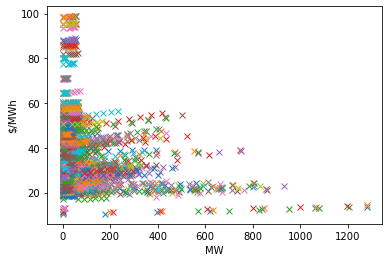

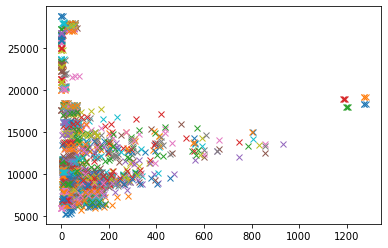

In [133]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# read in csv
df = pd.read_csv("gen_step_4.csv")

# add information for start heats, unit group based on dictionary lookup
start_heat = {
    "Solar Photovoltaic": [0,0,0],
    "Petroleum Coke": [68,44,38],
    "Other Gases": [68,44,38],
    "Onshore Wind Turbine": [0,0,0],
    "Nuclear": [78978, 0, 9999],
    "Natural Gas Steam Turbine":  [1457.4, 1122.5,452.8],
    "Natural Gas Fired Combustion Turbine": [1457.4, 1122.5,452.8],
    "Natural Gas Internal Combustion Engine": [7215.1, 4536.1, 3196.6],
    "Natural Gas Fired Combined Cycle": [7215.1, 4536.1, 3196.6],
    "Conventional Steam Coal": [45437, 36480, 27540],
    "Conventional Hydroelectric": [0,0,0],
    "Batteries": [0,0,0],
    "All Other": [0,0,0],
    "Wood/Wood Waste Biomass": [0,0,0],
    "Other Waste Biomass": [0,0,0]
}

output_pct_dict = {
    "Solar Photovoltaic": [0,0,0,0],
    "Petroleum Coke": [0.4,0.6,0.8,1.0],
    "Other Gases": [0.1,0.5,0.8,1.0],
    "Onshore Wind Turbine": [0,0,0,0],
    "Nuclear": [0.12,0.993, 0.996, 1],
    "Natural Gas Steam Turbine": [0.4,0.5,0.75,1],
    "Natural Gas Fired Combustion Turbine": [0.4,0.6,0.8,1],
    "Natural Gas Internal Combustion Engine": [0.478, 0.652, 0.827, 1], 
    "Natural Gas Fired Combined Cycle":[0.478, 0.652, 0.827, 1],
    "Conventional Steam Coal": [0.25,0.35,0.7,1],
    "Conventional Hydroelectric": [1,0,0,0],
    "All Other": [0.4,0.6,0.8,1],
    "Batteries": [1,0,0,0],
    "Wood/Wood Waste Biomass": [0,0,0,0],
    "Other Waste Biomass": [0,0,0,0]
}

df.dropna(subset=["Unit Type"], inplace=True)

df["Start Heat Cold MBTU"] = df["Unit Type"].apply(lambda x: start_heat.get(x)[0])
df["Start Heat Warm MBTU"] = df["Unit Type"].apply(lambda x: start_heat.get(x)[1])
df["Start Heat Hot MBTU"] = df["Unit Type"].apply(lambda x: start_heat.get(x)[2])

#df["Output_pct_0"] = df.apply(lambda x: (x["PMin MW"]/x["PMax MW"]), axis=1)
df["Output_pct_0"] = df.apply(lambda x: (x["PMin MW"]/x["PMax MW"]), axis=1)
df["Output_pct_1"] = df["Unit Type"].apply(lambda x: output_pct_dict.get(x)[1])
df["Output_pct_2"] = df["Unit Type"].apply(lambda x: output_pct_dict.get(x)[2])
df["Output_pct_3"] = df["Unit Type"].apply(lambda x: output_pct_dict.get(x)[3])

def create_unit_group(x):
    if(x["Unit Type"] in ["Solar Photovoltaic", "Wind", "Batteries", "Onshore Wind Turbine"]):
        return x["Unit Type"]
    else:
        return "U{}".format(int(x["PMax MW"]))   
    

df["Unit Group"] = df.apply(create_unit_group, axis=1)
# causes validation errors with prescient if not rounded to 1/10
df["PMin MW"] = df["PMin MW"].apply(lambda x: round(x,1))
df["PMax MW"] = df["PMax MW"].apply(lambda x: round(x,1))

# function based on Ronnie's script that can be applied elementwise
def apply_interpolation(x):
    if(x["Unit Type"] in ["Solar Photovoltaic", "Wind", "Batteries", "Onshore Wind Turbine"]):
        """
        x["HR_avg_0"] = 0
        x["HR_incr_1"] = 0
        x["HR_incr_2"] = 0
        x["HR_incr_3"] = 0
        """
        return pd.Series([x["GEN UID"],0,0,0,0], index = ["GEN UID","HR_avg_0", "HR_incr_1", "HR_incr_2", "HR_incr_3"])
    # Variable Definitions
    fuel_cost = x["Fuel Price $/MMBTU"] # fuel cost for bus number 111184 (cell D2 of powerworld_curves.csv provided by ER)
    # units: $/BTU
    #MWh breaks in heat cost curve for bus 111184 (cells E,G,I,K,M2 of powerworld_curves.csv)
    mw = np.array([0, x["MW Break 1"], x["MW Break 2"], x["MW Break 3"], x["MW Break 4"], x["MW Break 5"], x["PMax MW"]]) # units: MWh
    # MWh price in heat cost curve for bus 111184 (cells F,H,J,L,N2 in powerworld_curves.csv)
    slope = (x["MWh Price 5"]-x["MWh Price 4"])/(x["MW Break 5"] - x["MW Break 4"])
    y_fin = (slope *(x["PMax MW"] - x["MW Break 5"])) + x["MWh Price 5"]
    print((x["MWh Price 5"]-x["MWh Price 4"])/(x["MW Break 5"] - x["MW Break 4"]))
    print((x["MWh Price 4"]-x["MWh Price 3"])/(x["MW Break 4"] - x["MW Break 3"]))
    print((x["MWh Price 3"]-x["MWh Price 2"])/(x["MW Break 3"] - x["MW Break 2"]))
    mwh_price = np.array([x["MWh Price 1"],x["MWh Price 1"], x["MWh Price 2"], x["MWh Price 3"], x["MWh Price 4"], x["MWh Price 5"], y_fin]) # Units: $/MWh
    plt.figure(1)
    plt.plot(mw, mwh_price, 'x')
    plt.xlabel("MW")
    plt.ylabel("$/MWh")
    BTU_per_kWh = (mwh_price / fuel_cost) * 1000
    output_pct = np.array([x["Output_pct_0"], x["Output_pct_1"], x["Output_pct_2"], x["Output_pct_3"]])
    PMax = x["PMax MW"]
    
    interpolated = interp1d(mw, BTU_per_kWh, kind='linear')
    HR = interpolated(output_pct * PMax)
    plt.figure(2)
    plt.plot(output_pct*PMax, HR, 'x')
    print((HR[3]-HR[2])/(output_pct[3]*PMax-output_pct[2]*PMax))
    print((HR[2]-HR[1])/(output_pct[2]*PMax-output_pct[1]*PMax))
    print((HR[1]-HR[0])/(output_pct[1]*PMax-output_pct[0]*PMax))
    print(output_pct)
    
    return pd.Series([x["GEN UID"], HR[0], HR[1]-HR[0], HR[2]-HR[1], HR[3]-HR[2]], index = ["GEN UID", "HR_avg_0", "HR_incr_1", "HR_incr_2", "HR_incr_3"])
    # plt.figure(2)
    # plt.plot(output_pct, HR_average)
hr = df.apply(apply_interpolation, axis=1)


df = df.merge(hr, on="GEN UID", validate="one_to_one")
#print(apply_interpolation(df.loc[7]))
#apply_interpolation()
df.dropna(subset=["Ramp Rate MW/Min"], inplace=True)

df.to_csv("./gen_step_5.csv")

In [134]:
df = pd.read_csv("./gen_step_5.csv")

df["Name of Bus"] = df["Name of Bus"].str.replace(" ", "_")
df["Name of Bus"] = [x[:-2] for x in df["Name of Bus"]]

df = df[df["Fuel"] != "WH (Waste Heat)"]
df = df[df["Fuel"] != "WDS (Wood/Wood Waste Solids)"]
#df = df[df["Fuel"] != "NUC (Nuclear)"]
df = df[df["Unit Type"] != "Other Gases"]

df.to_csv("./TX_data/SourceData/gen.csv")

In [51]:
bus = pd.read_csv("./bus_step_1.csv")

bus["Bus Name"] = bus["Bus Name"].str.replace(" ", "_")
bus["Sub Name"] = bus["Sub Name"].str.replace(" ", "_")

bus.to_csv("./TX_data/SourceData/bus.csv")

branch = pd.read_csv("./branch_step_1.csv")

branch["From Name"] = branch["From Name"].str.replace(" ", "_")
branch["To Name"] = branch["To Name"].str.replace(" ", "_")

branch.to_csv("./TX_data/SourceData/branch.csv")

In [49]:
# match the UIDs to the NREL data
wind_map = pd.read_csv("./NREL_data/Texas7k_NREL_wind_map.csv")
wind_map["GEN UID"] = wind_map.apply(lambda x: "{}_OnshoreWindTurbine_{}".format(x["EIA-860 Plant Code"], x["Texas7k GenID"]), axis=1)
wind_map.to_csv("./NREL_data/Texas7k_NREL_wind_map.csv")

FileNotFoundError: [Errno 2] No such file or directory: './NREL_data/Texas7k_NREL_wind_map.csv'